In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle

%matplotlib inline

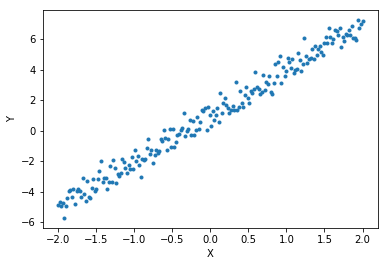

In [2]:
N = 200  # size of toy data

def build_linear_dataset(N, noise_std=0.5):
    X = np.linspace(-2, 2, num=N)
    Y = 3 * X + 1 + np.random.normal(0, noise_std, size=N)
    X, Y = X.reshape((N, 1)), Y.reshape((N, 1))
    return X, Y

def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys

X, Y = build_linear_dataset(N)

X_var = Variable(torch.Tensor(X))
Y_var = Variable(torch.Tensor(Y))

plt.plot(X, Y, '.');
plt.xlabel('X');
plt.ylabel('Y');

In [3]:
class MDN(nn.Module):
    def __init__(self, ndim_input=1, ndim_output=1, n_hidden=5, n_components=1):
        super(MDN, self).__init__()
        self.fc_in = nn.Linear(1, n_hidden)
        self.tanh = nn.Tanh()
        self.alpha_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softmax()
            )
        self.logsigma_out = nn.Linear(n_hidden, n_components)
        self.mu_out = nn.Linear(n_hidden, n_components)  

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_alpha = self.alpha_out(act)
        out_sigma = torch.exp(self.logsigma_out(act))
        out_mu = self.mu_out(act)
        return (out_alpha, out_sigma, out_mu)

In [4]:
def gauss_pdf(y, mu, sigma, log=False):
    result = -0.5*torch.log(2*np.pi*sigma**2) - 1/(2*sigma**2) * (y.expand_as(mu) - mu)**2
    if log:
        return result
    else: 
        return torch.exp(result)

def mdn_loss_function(out_alpha, out_sigma, out_mu, y):
    result = (gauss_pdf(y, out_mu, Variable(torch.ones((1)))) * out_alpha).squeeze()
    result = torch.log(result)
    result = torch.mean(result)  # mean over batch
    return -result

In [31]:
model = MDN()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

def train(X, Y, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
            
            (out_alpha, out_sigma, out_mu) = model(x_var)
            loss = mdn_loss_function(out_alpha, out_sigma, out_mu, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
        
train(X, Y)

[epoch 0050] loss: 1.2939
[epoch 0100] loss: 1.0572
[epoch 0150] loss: 1.0565
[epoch 0200] loss: 1.0090
[epoch 0250] loss: 1.0403
[epoch 0300] loss: 1.0441
[epoch 0350] loss: 1.0886
[epoch 0400] loss: 1.0491
[epoch 0450] loss: 1.0631
[epoch 0500] loss: 1.0976


In [29]:
X.shape

(200, 1)

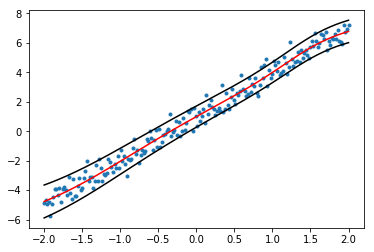

In [6]:
X_var = Variable(torch.Tensor(X))
Y_var = Variable(torch.Tensor(Y))

(out_alpha, out_sigma, out_mu) = model(X_var)

plt.plot(X, Y, '.')
plt.plot(X, out_mu.data.numpy(), '-r');
plt.plot(X, out_mu.data.numpy() + out_sigma.data.numpy(), '-k');
plt.plot(X, out_mu.data.numpy() - out_sigma.data.numpy(), '-k');

In [24]:
(out_alpha, out_sigma, out_mu) = model(X_var)
mdn_loss_function(out_alpha, out_sigma, out_mu, Y_var)

Variable containing:
 1.0483
[torch.FloatTensor of size 1]

In [25]:
y_var

NameError: name 'y_var' is not defined